<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



#Desafio 2

##Alumna: Maria Fabiana Cid

Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
Graficarlos.
Obtener conclusiones.

### 1. Adecuación de las librerias necesarias y compatibles

In [3]:
!pip uninstall scipy -y


Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3


In [4]:
!pip install scipy==1.9.3



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.4/33.4 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 29.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cvxpy 1.6.5 requires scipy>=1.11.0, but you have scipy 1.9.3 which is incompatible.
jaxlib 0.5.1 requires scipy>=1.11.1, but you have scipy 1.9.3 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.9.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.2 which is incompatible.
stumpy 1.13.0 requires scipy>=1.10, but you have scipy 1.9.3 which is incompatible.
blosc2

In [1]:

!pip install gensim==4.3.3 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 75.4 MB/s eta 0:00:00


In [2]:
import numpy as np
print(np.__version__)


1.25.2


In [3]:
import scipy
print(scipy.__version__)


1.9.3


In [4]:
!python --version

Python 3.11.12


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import multiprocessing
from gensim.models import Word2Vec

### 2. Datos
####Utilizaremos como dataset el texto del libro "El Arte de la Guerra" obtenido de la página https://www.textos.info/
El pdf descargado del libro "El Arte de la Guerra" lo guardo en mi drive.

Instalamos la librería Pymupdgf para:

Leer, analizar y extraer contenido de archivos PDF.

Extraer texto, imágenes, metadatos y estructuras de documentos.

Modificar PDFs (añadir texto, imágenes, anotar, etc.).

In [6]:
# Instalar la librería necesaria
!pip install --quiet pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 39.2 MB/s eta 0:00:00


In [7]:

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
import fitz  # PyMuPDF


Convertimos el libro descargado en pdf a TXT para que sea más facil el trabajo

In [9]:

# Ruta al archivo PDF
pdf_path = '/content/drive/MyDrive/El Arte de la Guerra.pdf'

# Ruta donde guardar el TXT
txt_path = '/content/drive/MyDrive/El Arte de la Guerra.txt'

# Abrir el PDF y extraer texto
doc = fitz.open(pdf_path)
text = ''
for page in doc:
    text += page.get_text()
doc.close()

# Guardar texto en .txt
with open(txt_path, 'w', encoding='utf-8') as f:
    f.write(text)

print(f'✅ Convertido: {os.path.basename(pdf_path)} → {os.path.basename(txt_path)}')


✅ Convertido: El Arte de la Guerra.pdf → El Arte de la Guerra.txt


In [10]:
file_path = '/content/drive/My Drive/El Arte de la Guerra.txt'

Verificamos si un archivo está disponible antes de abrirlo.

In [11]:

print(os.path.exists(file_path))


True


In [12]:

# Leer el archivo y limpiar los saltos de línea
with open(file_path, 'r') as file:
    lines = [line.strip() for line in file.readlines()]  # .strip() quita \n y espacios

# Crear el DataFrame
df = pd.DataFrame(lines, columns=["Text"])

# Mostrar las primeras 5 filas limpias
print("Primeras líneas del archivo:")
print(df.head())

# 🔍 Filtro: buscar líneas que contengan una palabra clave (ejemplo: "sabio")
palabra_clave = "sabio"
df_filtrado = df[df["Text"].str.contains(palabra_clave, case=False)]

# Mostrar resultados filtrados
print(f"\nLíneas que contienen la palabra '{palabra_clave}':")
print(df_filtrado)


Primeras líneas del archivo:
                         Text
0        El Arte de la Guerra
1                     Sun Tzu
2                 textos.info
3  Biblioteca digital abierta
4                           1

Líneas que contienen la palabra 'sabio':
                                                   Text
49                 ¿Qué dirigente es más sabio y capaz?
99    tengas consejeros sabios, al final no podrás h...
779   El beneficio y el daño son interdependientes, ...
1454  gobierno inteligente y a un mando militar sabi...
1503  Así, sólo un gobernante brillante o un general...


In [13]:
with open(file_path, 'r') as file:
    lines = file.readlines()

df = pd.DataFrame(lines, columns=["Text"])
df.head()


,Text
0,El Arte de la Guerra\n
1,Sun Tzu\n
2,textos.info\n
3,Biblioteca digital abierta\n
4,1\n


In [14]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1585


### 3. Preprocesamiento

Preparar texto. Reducir el "ruido" del lenguaje y conservar solo las palabras más informativas.

In [36]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

stop_words = list(set([
    # Artículos, conectores y palabras comunes
    'el', 'la', 'los', 'las', 'un', 'una', 'unos', 'unas', 'que', 'en', 'a', 'se', 'no', 'es',
    'si', 'así', 'te', 'ni', 'tu', 'para', 'cuando', 'por', 'lo', 'de', 'del', 'como', 'muchas',
    'según', 'y', 'tras', 'incluso', 'le', 'o', 'más', 'pero', 'donde', 'esto', 'todo', 'éste',
    'eso', 'ha', 'sino', 'tanto', 'cada', 'c', 'han', 'también', 'ningún', 'antes', 'al',
    'durante', 'ésta','muy', 'sí','uno' ,'dos', 'pues', 'cómo'

    # Pronombres personales
    'yo', 'tú', 'vos', 'él', 'ella', 'nosotros', 'nosotras', 'ustedes', 'ellos', 'ellas',

    # Pronombres objeto y reflexivos
    'me', 'nos', 'os', 'lo', 'la', 'los', 'las', 'le', 'les',

    # Pronombres posesivos
    'mi', 'mis', 'tus', 'su', 'sus', 'nuestro', 'nuestra', 'nuestros', 'nuestras',
    'vuestro', 'vuestra', 'vuestros', 'vuestras',

    # Pronombres demostrativos
    'este', 'esta', 'estos', 'estas', 'ese', 'esa', 'esos', 'esas', 'aquel', 'aquella', 'aquellos', 'aquellas',

    # Pronombres relativos
    'quien', 'quienes', 'cuyo', 'cuya', 'cuyos', 'cuyas',

    # Pronombres interrogativos y exclamativos
    'qué', 'quién', 'quiénes', 'cuál', 'cuáles', 'cuánto', 'cuánta', 'cuántos', 'cuántas',

    # Pronombres indefinidos
    'algo', 'alguien', 'alguno', 'alguna', 'algunos', 'algunas', 'nada', 'nadie', 'ninguno', 'ninguna',

    # Conectores
    'además', 'aunque', 'sin embargo', 'entonces', 'mientras', 'luego', 'después', 'ahora',
    'porque', 'ya que', 'puesto que', 'debido a', 'por lo tanto', 'por consiguiente', 'en cambio',
    'a pesar de', 'por ejemplo', 'incluso', 'asimismo', 'por ende', 'en efecto', 'en resumen',
    'finalmente', 'en conclusión', 'por otro lado', 'de hecho'
]))


sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones en una secuencia de palabras
for _, row in df[:None].iterrows():
    words = text_to_word_sequence(row[0])
    filtered_words = [word for word in words if word not in stop_words]  # Filtrar palabras vacías
    sentence_tokens.append(filtered_words)

# Mostrar el resultado
print(sentence_tokens[:2])


[['arte', 'guerra'], ['sun', 'tzu']]


<ipython-input-36-3340c9ed6310>:44: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



### 4. Crear los vectores (word2vec)

In [37]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [38]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [39]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [40]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 1585


In [41]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 314


### 5. Entrenar embeddings

In [42]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=50,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 58613.078125
Loss after epoch 1: 44603.3984375
Loss after epoch 2: 19801.0
Loss after epoch 3: 16333.9765625
Loss after epoch 4: 16155.890625
Loss after epoch 5: 16294.40625
Loss after epoch 6: 16422.453125
Loss after epoch 7: 16139.84375
Loss after epoch 8: 15937.640625
Loss after epoch 9: 16079.015625
Loss after epoch 10: 16396.5625
Loss after epoch 11: 16169.546875
Loss after epoch 12: 16025.84375
Loss after epoch 13: 16163.46875
Loss after epoch 14: 16078.34375
Loss after epoch 15: 16195.0
Loss after epoch 16: 16245.96875
Loss after epoch 17: 15665.5625
Loss after epoch 18: 15771.6875
Loss after epoch 19: 16068.0625
Loss after epoch 20: 16084.59375
Loss after epoch 21: 16642.875
Loss after epoch 22: 16856.09375
Loss after epoch 23: 16542.3125
Loss after epoch 24: 15773.65625
Loss after epoch 25: 16159.34375
Loss after epoch 26: 15848.5625
Loss after epoch 27: 16404.25
Loss after epoch 28: 16455.25
Loss after epoch 29: 15891.3125
Loss after epoch 30: 16335.0625
L

(142449, 400600)

### 6 - Ensayar

In [43]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["guerra"], topn=10)

[('arte', 0.9558084607124329),
 ('rey', 0.9551306962966919),
 ('caso', 0.9383078813552856),
 ('tratado', 0.936272919178009),
 ('wu', 0.9341031908988953),
 ('victorias', 0.9338752031326294),
 ('momento', 0.9334957599639893),
 ('llevar', 0.9304214119911194),
 ('resultado', 0.9250537157058716),
 ('dice', 0.924990177154541)]

In [44]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["guerra"], topn=10)

[('conoces', -0.58696049451828),
 ('quiere', -0.6288878321647644),
 ('decir', -0.6429516673088074),
 ('ti', -0.6468744874000549),
 ('demás', -0.683297872543335),
 ('hacia', -0.7249849438667297),
 ('cinco', -0.743626594543457),
 ('operaciones', -0.7528343200683594),
 ('mismo', -0.7541045546531677),
 ('clases', -0.7585919499397278)]

In [45]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["disciplina"], topn=10)

[('dispersión', 0.9937865138053894),
 ('debe', 0.9849969148635864),
 ('entre', 0.9846242666244507),
 ('posición', 0.983004629611969),
 ('hace', 0.9813955426216125),
 ('cerca', 0.9812566041946411),
 ('pueblo', 0.9788858294487),
 ('otros', 0.9763461351394653),
 ('resultado', 0.9752551913261414),
 ('favorable', 0.9749770760536194)]

In [46]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["enemigo"], topn=5)

[('provisiones', 0.9913721084594727),
 ('fuerte', 0.9898176789283752),
 ('esté', 0.9876061081886292),
 ('ejército', 0.9867382645606995),
 ('confusión', 0.9861343502998352)]

In [47]:
# Ensayar con una palabra que no está en el vocabulario:
w2v_model.wv.most_similar(negative=["nube"])

KeyError: "Key 'nube' not present in vocabulary"

In [48]:
# el método `get_vector` permite obtener los vectores:
vector_guerra = w2v_model.wv.get_vector("guerra")
print(vector_guerra)

[ 0.03366455  0.19947991 -0.03355204 -0.01715589  0.09803902 -0.12900905
  0.05134622  0.26677352  0.01157734 -0.14655636  0.10562631 -0.16699383
  0.0654561  -0.02849409 -0.09019139 -0.04615823  0.09572779 -0.05655101
 -0.03143979 -0.03622947 -0.11036372 -0.07638603 -0.04083797  0.05219264
  0.07801197 -0.02980549 -0.10827614 -0.10041489 -0.03175403 -0.01083619
  0.02491311 -0.12939708 -0.00132855 -0.05585629 -0.09306917  0.05107591
  0.06497268 -0.05260075  0.01932642 -0.02021016 -0.0692703   0.02701413
 -0.03000806 -0.08860569  0.22158599  0.20742072  0.18139994  0.06823985
  0.06027056  0.0785998  -0.01379836 -0.03160435 -0.06074496  0.10674302
 -0.1030986   0.16180916  0.02902289  0.02229116 -0.02072359  0.00990518
  0.03687481  0.06185397 -0.10362768  0.09953988  0.0147394  -0.02357672
  0.03986721 -0.07267752 -0.09137934 -0.18502833  0.032803    0.00105312
  0.2467944  -0.11743256 -0.10576534  0.06797838 -0.17288215  0.01579326
  0.01365969  0.18422982 -0.04339241 -0.16902024  0

In [49]:
# el método `most_similar` también permite comparar a partir de vectores
w2v_model.wv.most_similar(vector_guerra)

[('guerra', 1.0),
 ('arte', 0.9558084607124329),
 ('rey', 0.9551306962966919),
 ('caso', 0.9383078813552856),
 ('tratado', 0.936272919178009),
 ('wu', 0.9341031908988953),
 ('victorias', 0.9338752031326294),
 ('momento', 0.9334957599639893),
 ('llevar', 0.9304214119911194),
 ('resultado', 0.9250537157058716)]

In [50]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["fuerza"], topn=10)

[('tímido', 0.9871295690536499),
 ('valiente', 0.9861152768135071),
 ('ímpetu', 0.9839007258415222),
 ('siempre', 0.9815329909324646),
 ('abierto', 0.9810523390769958),
 ('actuar', 0.9809233546257019),
 ('ataque', 0.9776528477668762),
 ('cuestión', 0.977504551410675),
 ('atacar', 0.9774413704872131),
 ('principio', 0.9763303399085999)]

### 7. Visualizar agrupación de vectores

In [51]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [52]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

In [53]:
# Graficar los embedddings en 3D

vecs, labels = reduce_dimensions(w2v_model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.show(renderer="colab") # esto para plotly en colab

###Ensayos adicionales

In [54]:
# TEST DE ANALOGÍAS
# ===============================
analogias = [

      ['batalla', 'soldados', 'guerra'],

]


print("=== Resultados de analogías ===")
for triple in analogias:
    a, b, c = triple
    try:
        resultado = w2v_model.wv.most_similar(positive=[a, c], negative=[b], topn=3)
        print(f"\n{a} - {b} + {c} ≈ ?")
        for palabra, score in resultado:
            print(f"  {palabra} ({score:.3f})")
    except KeyError as e:
        print(f"\n❌ Palabra no encontrada en el vocabulario: {e}")

=== Resultados de analogías ===

batalla - soldados + guerra ≈ ?
  arte (0.937)
  dice (0.926)
  rey (0.922)


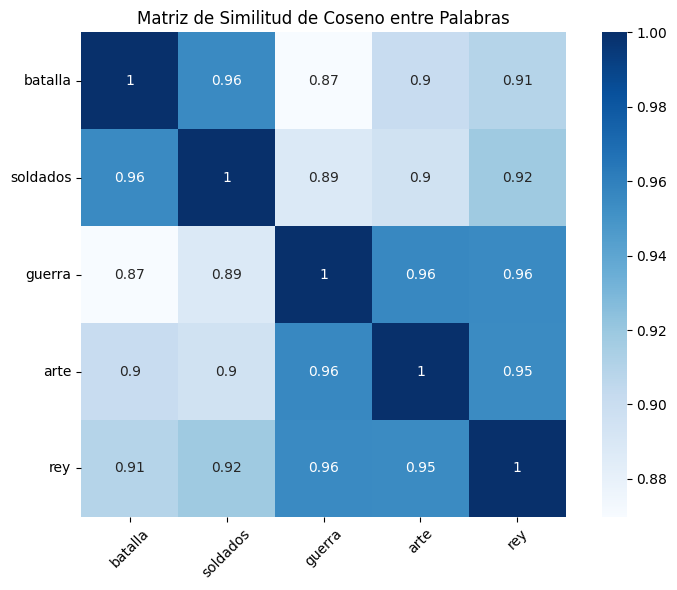

In [55]:

from sklearn.metrics.pairwise import cosine_similarity

# Lista de palabras a comparar
palabras_analogia = ['batalla', 'soldados', 'guerra', 'arte', 'rey']

# Filtrar palabras que estén en el vocabulario del modelo
palabras_validas = [w for w in palabras_analogia if w in w2v_model.wv]

# Obtener vectores
vectores = np.array([w2v_model.wv[w] for w in palabras_validas])

# Calcular similitud de coseno entre pares de palabras
matriz_similitud = cosine_similarity(vectores)

# Función para graficar matriz de similitud
def plot_matrix_distance(words, matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, xticklabels=words, yticklabels=words, annot=True, cmap='Blues', square=True)
    plt.title("Matriz de Similitud de Coseno entre Palabras")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Graficar
plot_matrix_distance(palabras_validas, matriz_similitud)


## Conclusiones

Es fundamental poder realizar siempre un buen trabajo de preprocesamiento de los datos. Para ello, se eliminaron los saltos de línea (\n) y espacios en blanco y además se sacaron todos los pronombres, conectores que creaban ruido en el corpus.
Luego se hicieron distintas pruebas de similitud con varias palabras clave. En general los resultados fueron muy buenos. Se probó también con una palabra ("nube" ) que no pertenece al corpus.

Se graficaron los embeddings en 2D y 3D para ver relaciones entre las palabras.
Se observan agrupaciones de palabras con significados relacionados, lo cual indica que el modelo captó relaciones semánticas.

Por ejemplo:

Cerca de "batalla", "frente", "enemigas", "tropas", "victoria", etc., hay un grupo relacionado con el combate.

Otro grupo alrededor de "generales", "oficiales", "legiones", "tropas", "formación" que sugiere un contexto militar jerárquico.

Palabras como "energía", "defensa", "ataque", "fuego", "punto" se agrupan en torno a conceptos de estrategia y movimiento.

"general", "oficiales", "príncipe" están cercanas a palabras como "gobierno", "superiores", "órdenes", lo que sugiere que el modelo entendió relaciones de autoridad o rol.

"enemigo", "ataca", "adversario", "vence" están en regiones próximas → relación causa-efecto o acción-reacción.

Finalmente hicimos un test de analogia con operaciones con embeddings.
 En la matriz de similitud vemos que las similitudes  son muy altas (≥ 0.95): guerra –arte (0.96)

guerra – rey (0.96)

arte – rey (0.95)

Esto sugiere que en el corpus o modelo usado, "arte" aparece en un contexto más militar o estratégico (como "el arte de la guerra", por ejemplo), no en sentido estético.

"batalla" y "soldados" (0.96):
Es lógico: ambas se relacionan estrechamente con combate, guerra, conflicto.

 "batalla" tiene similitud ligeramente menor con "guerra" (0.87):
Podría parecer contraintuitivo, pero esto ocurre porque:

"batalla" es un evento específico,

"guerra" es más general o abstracto,

Puede haber diferencias de uso en el corpus.

Todas las palabras están altamente relacionadas (todos los valores ≥ 0.87):
Esto indica que el modelo aprendió correctamente asociaciones semánticas y que estas palabras aparecen en contextos similares.

✅ Conclusión general:
El modelo de embeddings ( Word2Vec) capturó bien las relaciones semánticas entre conceptos militares e históricos. Incluso “arte” se relaciona fuertemente con “guerra” y “rey”, lo cual puede deberse a expresiones como “el arte de gobernar”, “el arte de la guerra”, etc.

